In [351]:
# Import Libraries

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay, make_scorer, mean_squared_error,classification_report,confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

%matplotlib inline

In [297]:
# Import each dataset seperately, assign to dataframes

df_customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
df_engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
df_marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
df_transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [298]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [299]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [300]:
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [301]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [302]:
# 'customer_id'
# 'join_date'
# 'last_purchase_date'
# 'age'
# 'gender'
# 'location'
# 'number_of_site_visits'
# 'number_of_emails_opened'
# 'number_of_clicks'
# 'campaign_id'
# 'response'
# 'promotion_type'
# 'campaign_date'
# 'transaction_id'
# 'transaction_date'
# 'transaction_amount'
# 'product_category'

In [303]:
# make transactions and marketing indexes as customer_id for easy joining
df_transactions.set_index('customer_id', inplace=True)
df_marketing.set_index('customer_id', inplace=True)

In [304]:
# Convert dates to datetime objects -- cleaning

df_marketing['campaign_date'] = pd.to_datetime(df_marketing['campaign_date'])
df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'])

In [305]:
# Merge Customers and Engagement on 'customer_id'
merged_df = df_customers.merge(df_engagement, on='customer_id', suffixes=('_customer', '_engagement'))

# Merge the result with Transactions on 'customer_id'
transaction_level = merged_df.merge(df_transactions, on='customer_id', suffixes=('', '_transaction'))

In [306]:
# reset index
transaction_level.reset_index(inplace=True)

In [307]:
# reset index
df_marketing.reset_index(inplace=True)

In [308]:
# merge function we'll use requires sorting
transaction_level.sort_values(by=['customer_id','transaction_date'], inplace=True)
df_marketing.sort_values(by=['customer_id','campaign_date'], inplace=True)

In [309]:
# make sure sorting is correct
transaction_level[transaction_level['customer_id']==1]

,index,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [310]:
# make sure sorting is correct
df_marketing[df_marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
3,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
0,1,1,No,Buy One Get One,2024-02-29
2,1,3,No,Free Shipping,2024-03-05


In [311]:
# make sure data type is correct
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   index                    129545 non-null  int64         
 1   customer_id              129545 non-null  int64         
 2   join_date                129545 non-null  object        
 3   last_purchase_date       129545 non-null  object        
 4   age                      116463 non-null  float64       
 5   gender                   122525 non-null  object        
 6   location                 129545 non-null  object        
 7   number_of_site_visits    129545 non-null  int64         
 8   number_of_emails_opened  129545 non-null  int64         
 9   number_of_clicks         129545 non-null  int64         
 10  transaction_id           129545 non-null  int64         
 11  transaction_date         129545 non-null  datetime64[ns]
 12  transaction_amount   

In [312]:
transaction_level.head(15)

,index,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods
10,10,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,11,2021-09-29,1866.56,Electronics
8,8,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,2021-12-11,910.21,Electronics
12,12,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,13,2022-04-30,800.64,Home Goods
6,6,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,7,2022-05-05,443.99,Electronics


In [313]:
# make sure date datatype is correct
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25200 entries, 3 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customer_id     25200 non-null  int64         
 1   campaign_id     25200 non-null  int64         
 2   response        25200 non-null  object        
 3   promotion_type  25200 non-null  object        
 4   campaign_date   25200 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.2+ MB


In [314]:
# Custom function to find the most recent campaign before each transaction
def find_previous_campaign(transaction_row, campaigns):
    customer_campaigns = campaigns[campaigns['customer_id'] == transaction_row['customer_id']]
    customer_campaigns = customer_campaigns[customer_campaigns['campaign_date'] <= transaction_row['transaction_date']]
    if not customer_campaigns.empty:
        return customer_campaigns.iloc[-1]  # Return the most recent campaign
    else:
        return pd.Series([None] * campaigns.shape[1], index=campaigns.columns)

# Apply the custom function to each transaction
matched_campaigns = transaction_level.apply(find_previous_campaign, axis=1, campaigns=df_marketing)

# Merge the matched campaigns with transactions
df_merged = transaction_level.join(matched_campaigns.add_prefix('campaign_'))

In [315]:
# merge dataframe and check customer # 1
# we can see for each transaction, now we can see if there was a marketing campaign sent to the customer before they made the transaction, and whether they responded Yes or No
# if there was NOT a marketing campaign sent to them before they made the transaction, we get missing values > hint: don't impute these.
df_merged[df_merged['customer_id']==1]

,index,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT
3,3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10
0,0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24
4,4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24
1,1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29
2,2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05


In [316]:
# double check marketing aligns
df_marketing[df_marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
3,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
0,1,1,No,Buy One Get One,2024-02-29
2,1,3,No,Free Shipping,2024-03-05


In [317]:
# double check transactions are correct
transaction_level[transaction_level['customer_id']==1]

,index,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [318]:
# delete duplicate index column

df_merged.drop(columns=['index'], inplace=True)
transaction_level.drop(columns=['index'], inplace=True)

In [319]:
# verify done correctly

transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [320]:
# verify done correctly

df_merged[df_merged['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05


In [321]:
df_merged.groupby('customer_id')['transaction_amount'].sum()

customer_id
1         3509.48
2         6081.32
3         1454.87
4         7874.68
5        15524.55
           ...   
9996      5498.20
9997      5848.30
9998      3503.13
9999      6721.86
10000     5775.83
Name: transaction_amount, Length: 10000, dtype: float64

In [322]:
# Calculate LTV
customer_ltv = df_merged.groupby('customer_id')['transaction_amount'].sum().reset_index()
customer_ltv.rename(columns={'transaction_amount': 'LTV'}, inplace=True)

# Merge LTV back to df_merged
df_merged = df_merged.merge(customer_ltv, on='customer_id', how='left')

# Check the result
df_merged.head(15)

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date,LTV
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT,3509.48
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10,3509.48
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24,3509.48
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24,3509.48
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29,3509.48
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05,3509.48
6,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,11,2021-09-29,1866.56,Electronics,NaN,NaN,None,None,NaT,6081.32
7,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,2021-12-11,910.21,Electronics,2.0,6.0,No,Free Shipping,2021-11-12,6081.32
8,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,13,2022-04-30,800.64,Home Goods,2.0,6.0,No,Free Shipping,2021-11-12,6081.32
9,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,7,2022-05-05,443.99,Electronics,2.0,6.0,No,Free Shipping,2021-11-12,6081.32


In [323]:
# Max = 24,298.22
# Min = 23.81
# Mean = 10108.10

df_merged['LTV'].mean()

10108.104977652552

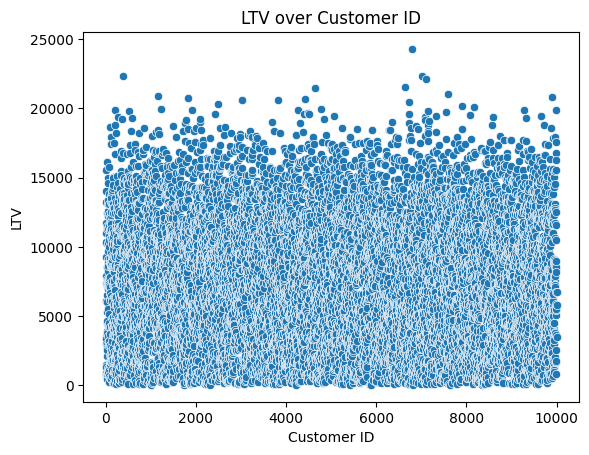

In [324]:
# Plot LTV by customer ID to see the data we're predicting
# Check for outliers that may negatively effect the models

# Ensure that the DataFrame has unique customer_id values
customer_ltv = df_merged.groupby('customer_id')['LTV'].mean().reset_index()

# Plot LTV over customer_id
sns.scatterplot(data=customer_ltv, x='customer_id', y='LTV')
plt.xlabel('Customer ID')
plt.ylabel('LTV')
plt.title('LTV over Customer ID')
plt.show()

<Axes: ylabel='LTV'>

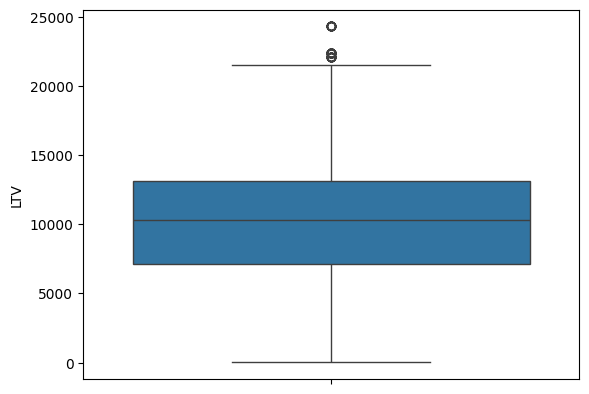

In [325]:
# Check Outliers

sns.boxplot(data=df_merged['LTV'])

In [326]:
# Further investigate if outlier should be removed

# Ensure customer_id is unique by dropping duplicates
unique_customers = df_merged.drop_duplicates(subset='customer_id')

# Filter and sort the DataFrame based on LTV
top_30_customers = unique_customers[['customer_id', 'LTV']].sort_values(by='LTV', ascending=False).head(30)

# Display the result
print(top_30_customers)

        customer_id       LTV
88047          6795  24298.22
91033          7016  22364.72
4790            386  22340.06
91988          7093  22102.83
86023          6633  21518.15
60011          4634  21478.81
98496          7584  21056.06
14807          1155  20918.62
128251         9902  20845.64
23554          1833  20780.89
57048          4417  20651.89
49606          3823  20601.69
39285          3022  20599.16
87087          6718  20433.38
32494          2501  20349.68
102841         7911  20205.42
106032         8170  20111.80
15811          1231  19981.33
61721          4771  19929.08
54986          4264  19897.23
2569            208  19879.39
24555          1917  19876.28
120131         9280  19875.94
129407         9991  19857.11
6546            522  19840.04
92668          7149  19814.04
98054          7546  19736.20
57986          4482  19670.93
87177          6725  19630.14
58550          4520  19565.23


In [327]:
# dropping 3 outliers for the model

df_merged = df_merged[~df_merged['customer_id'].isin([6795,386,7093])]

In [328]:
df_merged.columns

Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'transaction_id', 'transaction_date',
       'transaction_amount', 'product_category', 'campaign_customer_id',
       'campaign_campaign_id', 'campaign_response', 'campaign_promotion_type',
       'campaign_campaign_date', 'LTV'],
      dtype='object')

In [329]:
df_merged['LTV'].median()

10316.82

In [330]:
df_merged['LTV'].mean()

10101.093431190819

In [331]:
# Predicting exact LTV is unrealistic and going to be inaccurate so lets put customers into high or low, seperated at 10500 for a 70/30 split

# Define the midpoint threshold
midpoint_threshold = 10500

# Function to classify LTV
def classify_ltv(ltv):
    if ltv <= midpoint_threshold:
        return 'Low'
    else:
        return 'High'

# Apply the function to create a new column
df_merged['LTV_category'] = df_merged['LTV'].apply(classify_ltv)

# Display the first few rows to verify
print(df_merged[['customer_id', 'LTV', 'LTV_category']].head())

   customer_id      LTV LTV_category
0            1  3509.48          Low
1            1  3509.48          Low
2            1  3509.48          Low
3            1  3509.48          Low
4            1  3509.48          Low


In [332]:
# Drop duplicate customer_id entries
df_unique_customers = df_merged.drop_duplicates(subset='customer_id')

# Calculate the counts of each category
ltv_category_counts = df_unique_customers['LTV_category'].value_counts()

# Calculate the total number of unique entries
total_unique_entries = len(df_unique_customers)

# Calculate the percentage of each category
ltv_category_percentages = (ltv_category_counts / total_unique_entries) * 100

# Display the percentages
print(ltv_category_percentages)
# Display the total number of unique entries
print(f'Total number of unique entries: {total_unique_entries}')

LTV_category
Low     70.081024
High    29.918976
Name: count, dtype: float64
Total number of unique entries: 9997


In [333]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129474 entries, 0 to 129544
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129474 non-null  int64         
 1   join_date                129474 non-null  object        
 2   last_purchase_date       129474 non-null  object        
 3   age                      116392 non-null  float64       
 4   gender                   122454 non-null  object        
 5   location                 129474 non-null  object        
 6   number_of_site_visits    129474 non-null  int64         
 7   number_of_emails_opened  129474 non-null  int64         
 8   number_of_clicks         129474 non-null  int64         
 9   transaction_id           129474 non-null  int64         
 10  transaction_date         129474 non-null  datetime64[ns]
 11  transaction_amount       129474 non-null  float64       
 12  product_category     

In [334]:
# Convert join_date and last_purchase_date to datetime objects
df_merged['join_date'] = pd.to_datetime(df_merged['join_date'])
df_merged['last_purchase_date'] = pd.to_datetime(df_merged['last_purchase_date'])

# Display the first few rows to verify
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129474 entries, 0 to 129544
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129474 non-null  int64         
 1   join_date                129474 non-null  datetime64[ns]
 2   last_purchase_date       129474 non-null  datetime64[ns]
 3   age                      116392 non-null  float64       
 4   gender                   122454 non-null  object        
 5   location                 129474 non-null  object        
 6   number_of_site_visits    129474 non-null  int64         
 7   number_of_emails_opened  129474 non-null  int64         
 8   number_of_clicks         129474 non-null  int64         
 9   transaction_id           129474 non-null  int64         
 10  transaction_date         129474 non-null  datetime64[ns]
 11  transaction_amount       129474 non-null  float64       
 12  product_category     

In [335]:
# Drop null values from Age and Gender as we cannot impute these
df_merged = df_merged.dropna(subset=['age', 'gender'])

In [336]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110297 entries, 0 to 129544
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              110297 non-null  int64         
 1   join_date                110297 non-null  datetime64[ns]
 2   last_purchase_date       110297 non-null  datetime64[ns]
 3   age                      110297 non-null  float64       
 4   gender                   110297 non-null  object        
 5   location                 110297 non-null  object        
 6   number_of_site_visits    110297 non-null  int64         
 7   number_of_emails_opened  110297 non-null  int64         
 8   number_of_clicks         110297 non-null  int64         
 9   transaction_id           110297 non-null  int64         
 10  transaction_date         110297 non-null  datetime64[ns]
 11  transaction_amount       110297 non-null  float64       
 12  product_category     

In [337]:
# Calculate the duration in years
df_merged['duration_years'] = (df_merged['last_purchase_date'] - df_merged['join_date']).dt.days / 365.25

# Calculate the average yearly spend
df_merged['avg_yearly_spend'] = df_merged['LTV'] / df_merged['duration_years']

In [338]:
print(df_merged[df_merged['customer_id'] == 4][['customer_id', 'LTV', 'duration_years', 'avg_yearly_spend']])

    customer_id      LTV  duration_years  avg_yearly_spend
21            4  7874.68        0.665298      11836.324568
22            4  7874.68        0.665298      11836.324568
23            4  7874.68        0.665298      11836.324568
24            4  7874.68        0.665298      11836.324568
25            4  7874.68        0.665298      11836.324568
26            4  7874.68        0.665298      11836.324568
27            4  7874.68        0.665298      11836.324568
28            4  7874.68        0.665298      11836.324568
29            4  7874.68        0.665298      11836.324568
30            4  7874.68        0.665298      11836.324568
31            4  7874.68        0.665298      11836.324568
32            4  7874.68        0.665298      11836.324568
33            4  7874.68        0.665298      11836.324568
34            4  7874.68        0.665298      11836.324568
35            4  7874.68        0.665298      11836.324568
36            4  7874.68        0.665298      11836.3245

In [339]:
df_merged['duration_years'].describe()

count    110297.000000
mean          1.093993
std           0.971036
min           0.000000
25%           0.295688
50%           0.813142
75%           1.681040
max           4.334018
Name: duration_years, dtype: float64

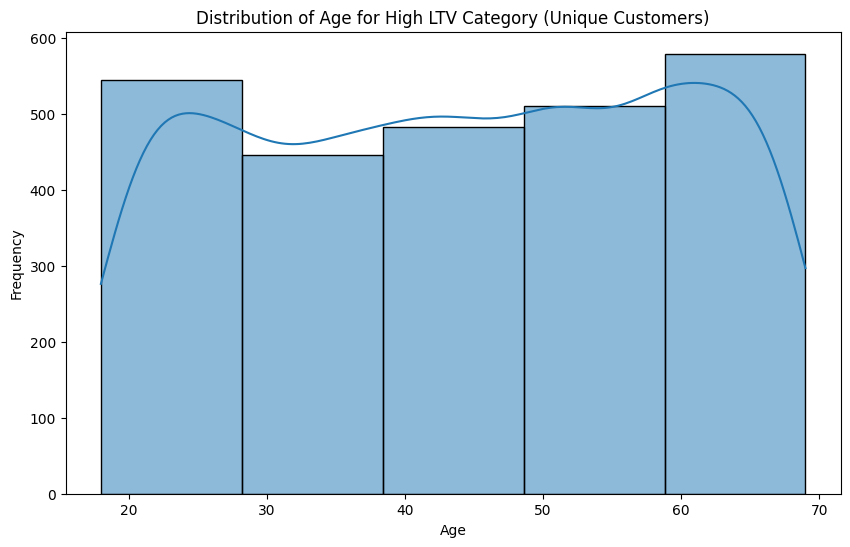

In [340]:
# Filter the DataFrame for high LTV category
high_ltv_df = df_merged[df_merged['LTV_category'] == 'High']

# Drop duplicate customer_id entries
high_ltv_df_unique = high_ltv_df.drop_duplicates(subset='customer_id')

# Create a plot
plt.figure(figsize=(10, 6))
sns.histplot(high_ltv_df_unique['age'], bins=5, kde=True)
plt.title('Distribution of Age for High LTV Category (Unique Customers)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [341]:
# Age Bins: 18-27, 28-37, 38-48, 49-59, 60+
# Define the bin edges and labels
bin_edges = [18, 27, 37, 48, 59, df_merged['age'].max() + 1]
bin_labels = ['18-27', '28-37', '38-48', '49-59', '60+']

# Assign the bins
df_merged['age_bin'] = pd.cut(df_merged['age'], bins=bin_edges, labels=bin_labels, right=False)

# Display the first few rows to verify
print(df_merged[['customer_id', 'age', 'age_bin']].head())

# Check the total number of unique customer_id's in each age bin
unique_customers_per_bin = df_merged.drop_duplicates('customer_id').groupby('age_bin')['customer_id'].nunique()
print(unique_customers_per_bin)

   customer_id   age age_bin
0            1  56.0   49-59
1            1  56.0   49-59
2            1  56.0   49-59
3            1  56.0   49-59
4            1  56.0   49-59
age_bin
18-27    1526
28-37    1617
38-48    1740
49-59    1794
60+      1842
Name: customer_id, dtype: int64


C:\Users\Berry\AppData\Local\Temp\ipykernel_7792\2782757842.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_customers_per_bin = df_merged.drop_duplicates('customer_id').groupby('age_bin')['customer_id'].nunique()


In [342]:
df_merged.columns

Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'transaction_id', 'transaction_date',
       'transaction_amount', 'product_category', 'campaign_customer_id',
       'campaign_campaign_id', 'campaign_response', 'campaign_promotion_type',
       'campaign_campaign_date', 'LTV', 'LTV_category', 'duration_years',
       'avg_yearly_spend', 'age_bin'],
      dtype='object')

In [343]:
df_merged.head(20)

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,...,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date,LTV,LTV_category,duration_years,avg_yearly_spend,age_bin
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,...,NaN,NaN,None,None,NaT,3509.48,Low,0.323066,10863.030254,49-59
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,...,1.0,4.0,Yes,Buy One Get One,2024-01-10,3509.48,Low,0.323066,10863.030254,49-59
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,...,1.0,2.0,No,Discount,2024-01-24,3509.48,Low,0.323066,10863.030254,49-59
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,...,1.0,2.0,No,Discount,2024-01-24,3509.48,Low,0.323066,10863.030254,49-59
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,...,1.0,1.0,No,Buy One Get One,2024-02-29,3509.48,Low,0.323066,10863.030254,49-59
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,...,1.0,3.0,No,Free Shipping,2024-03-05,3509.48,Low,0.323066,10863.030254,49-59
21,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,29,...,NaN,NaN,None,None,NaT,7874.68,Low,0.665298,11836.324568,28-37
22,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,38,...,NaN,NaN,None,None,NaT,7874.68,Low,0.665298,11836.324568,28-37
23,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,40,...,NaN,NaN,None,None,NaT,7874.68,Low,0.665298,11836.324568,28-37
24,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,28,...,NaN,NaN,None,None,NaT,7874.68,Low,0.665298,11836.324568,28-37


In [344]:
# Define the features and target variable

features = [
     'age_bin', 'product_category','duration_years',
    'number_of_clicks', 'number_of_emails_opened','transaction_amount',
    'number_of_site_visits', 'location', 'gender'
]
X = df_merged[features]
y = df_merged['LTV_category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Identify numeric and categorical columns
numeric_features = [ 'number_of_clicks','duration_years', 
                    'number_of_emails_opened','transaction_amount', 'number_of_site_visits']
categorical_features = ['age_bin', 'product_category',  
                        'location', 'gender']

# Define the numeric transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numeric and categorical transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the pipeline with preprocessor and logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Perform cross-validation and evaluate the model
accuracy_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)
f1_scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_macro', cv=5)

# Print the scores and the mean accuracy
print(f'Logistic Regression Accuracy Scores: {accuracy_scores}')
print(f'Logistic Regression Mean Accuracy: {accuracy_scores.mean()}')

print(f'Logistic Regression F1 Scores: {f1_scores}')
print(f'Logistic Regression Mean F1 Score: {f1_scores.mean()}')

Logistic Regression Accuracy Scores: [0.92041186 0.92280793 0.92390389 0.92079529 0.92358008]
Logistic Regression Mean Accuracy: 0.922299809341491
Logistic Regression F1 Scores: [0.92040648 0.92280372 0.92389261 0.92078568 0.92356267]
Logistic Regression Mean F1 Score: 0.9222902334373613


In [345]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['number_of_clicks',
                                                   'duration_years',
                                                   'number_of_emails_opened',
                                                   'transaction_amount',
                                                   'number_of_site_visits']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_bin',
                                                   'product_category',
                                                   'location', 'gender'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [346]:
pred = pipeline.predict(X_test)

In [347]:
# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Fit the logistic regression model
pipeline.fit(X_train, y_train_encoded)

# Make predictions
pred = pipeline.predict(X_test)

# Decode the predictions
pred_decoded = label_encoder.inverse_transform(pred)

# Compute the metrics
accuracy = accuracy_score(y_test, pred_decoded)
precision = precision_score(y_test, pred_decoded, pos_label='High')
recall = recall_score(y_test, pred_decoded, pos_label='High')
f1 = f1_score(y_test, pred_decoded, pos_label='High')



# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9227863402840737
Precision: 0.9030968434870815
Recall: 0.9420515374081913
F1 Score: 0.9221629855293222


In [ ]:
# Lets make a Random Forest classifier so we can see the importance value of each variable and compare performance

# Assuming df_merged is your DataFrame and it's already loaded
features = [
    'age_bin', 'product_category', 'duration_years',
    'number_of_clicks', 'number_of_emails_opened', 'transaction_amount',
    'number_of_site_visits', 'location', 'gender'
]
X = df_merged[features]
y = df_merged['LTV_category']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Identify numeric and categorical columns
numeric_features = ['number_of_clicks', 'duration_years', 
                    'number_of_emails_opened', 'transaction_amount', 'number_of_site_visits']
categorical_features = ['age_bin', 'product_category',  
                        'location', 'gender']

# Define the numeric transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine numeric and categorical transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the pipeline with preprocessor and random forest model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Get feature importances from the random forest model
rf_model = pipeline.named_steps['classifier']
feature_importances = rf_model.feature_importances_

# Get the feature names after one-hot encoding
preprocessed_feature_names = (
    pipeline.named_steps['preprocessor']
    .transformers_[1][1]
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

# Combine numeric and one-hot encoded feature names
feature_names = np.concatenate([numeric_features, preprocessed_feature_names])

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)

                      Feature    Importance
1              duration_years  6.813336e-02
4       number_of_site_visits  6.241189e-02
2     number_of_emails_opened  5.651200e-02
0            number_of_clicks  5.046419e-02
3          transaction_amount  4.696879e-02
...                       ...           ...
6134    location_West Crystal  9.831175e-07
1951    location_Jenniferstad  9.434092e-07
2251    location_Kimberlyview  9.090622e-07
2306  location_Lake Alvinport  8.414943e-07
269      location_Bendershire  6.702920e-07

[6648 rows x 2 columns]


In [ ]:
importance_df.head(30)

,Feature,Importance
1,duration_years,0.068133
4,number_of_site_visits,0.062412
2,number_of_emails_opened,0.056512
0,number_of_clicks,0.050464
3,transaction_amount,0.046969
6647,gender_Male,0.010079
7,age_bin_49-59,0.005689
6,age_bin_38-48,0.005667
8,age_bin_60+,0.005314
10,product_category_Home Goods,0.003222


In [ ]:
# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the performance metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print detailed classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy: 0.9830
Precision: 0.9830
Recall: 0.9833
F1 Score: 0.9830

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     16066
           1       0.99      0.97      0.98     17024

    accuracy                           0.98     33090
   macro avg       0.98      0.98      0.98     33090
weighted avg       0.98      0.98      0.98     33090



Confusion Matrix:
[[15080   986]
 [ 1606 15418]]


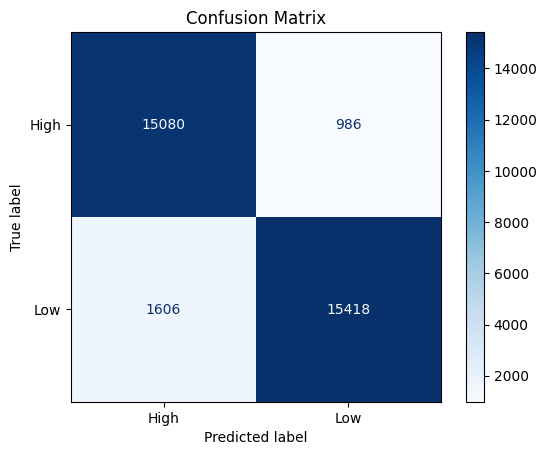

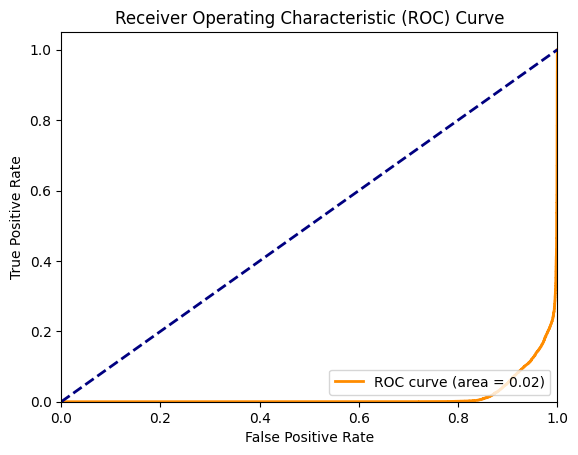

In [353]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets with encoded labels
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded)

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve and AUC
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=label_encoder.transform(['High'])[0])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix:
[[15067   999]
 [ 1575 15449]]


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


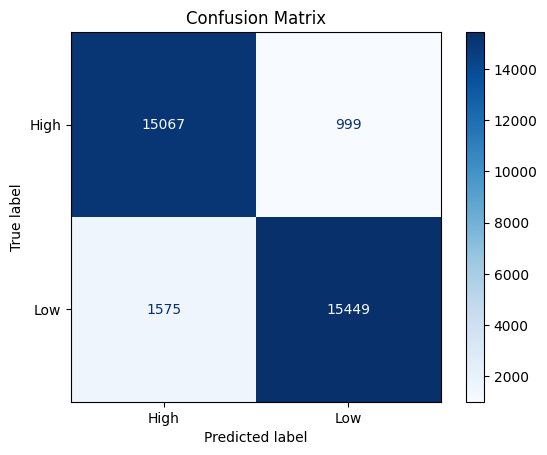

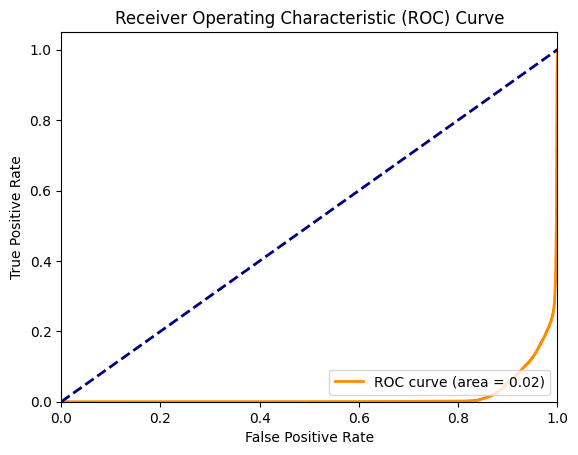

AUC: 0.02

Classification Report:
              precision    recall  f1-score   support

        High       0.91      0.94      0.92     16066
         Low       0.94      0.91      0.92     17024

    accuracy                           0.92     33090
   macro avg       0.92      0.92      0.92     33090
weighted avg       0.92      0.92      0.92     33090



In [356]:
# Assuming df_merged is your DataFrame and it's already loaded
features = [
    'age_bin', 'product_category', 'duration_years',
    'number_of_clicks', 'number_of_emails_opened', 'transaction_amount',
    'number_of_site_visits', 'location', 'gender'
]
X = df_merged[features]
y = df_merged['LTV_category']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets with encoded labels
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded)

# Define the numeric transformer
numeric_features = ['number_of_clicks', 'duration_years', 
                    'number_of_emails_opened', 'transaction_amount', 'number_of_site_visits']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define the categorical transformer
categorical_features = ['age_bin', 'product_category', 'location', 'gender']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine numeric and categorical transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the pipeline with preprocessor and logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit the logistic regression model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=label_encoder.transform(['High'])[0])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f'AUC: {roc_auc:.2f}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))